In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scripts import dataio as dataio

### Skalierung

In [2]:
def scale(x):
    # Set min/max attributes to reuse them for prediction
    xMin = x.min(axis=0)
    xMax = x.max(axis=0)
    # Scale x
    return (x - xMin) / (xMax - xMin), (xMin/xMax-1)*(xMax-xMin)*(-1)

### Tensorvorbereitung CNN-LSTM

In [3]:
def prepareData(forcing,streamflow,days):
    counter=days
    inputcounter=days
    inputTensor=np.ones((forcing.shape[0]*(365-days),counter,forcing.shape[2],forcing.shape[3],forcing.shape[4]), dtype='float32')
    targetTensor=np.ones((forcing.shape[0]*(365-days),1))
    year=0
    inputcounter=15
    while year<forcing.shape[0]:
        counter=days
        while counter<forcing.shape[1]:  
            rain = forcing[year,counter-days:counter]
            stream=streamflow[year,counter]
            inputTensor[inputcounter-days]=rain
            targetTensor[inputcounter-days]=stream
            counter+=1
            inputcounter+=1
        year+=1
    return inputTensor,targetTensor


### Tensorvorbereitung LSTM

In [4]:
def prepareTensor(forcing_numpy,streamflow_numpy,days):
    counter=days
    inputTensor = np.zeros((len(forcing_numpy)-counter,counter,5),float)
    targetTensor = streamflow_numpy[:len(forcing_numpy)-counter]
    while counter<len(forcing_numpy):
        rain = forcing_numpy[counter-days:counter]
        inputTensor[counter-days:counter-(days-1),:]=rain
        counter+=1
    inputTensor= np.reshape(inputTensor, (inputTensor.shape[0], inputTensor.shape[1],5))
    return inputTensor,targetTensor

### Zufälliges Mischen der Daten

In [5]:
def shuffle(forcingshuffle,streamflowshuffle):
    randomize = np.arange(len(forcingshuffle))
    np.random.shuffle(randomize)
    forcingshuffle = forcingshuffle[randomize]
    streamflowshuffle = streamflowshuffle[randomize]
    return forcingshuffle,streamflowshuffle

### Kompilieren, anpassen und ausgeben

In [7]:
def kompilierung(model: tf.keras.Model, inputs: np.ndarray, targets: np.ndarray,
                    validation: tuple, batch_size: int, epochs: int):
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.losses.MeanSquaredError(), tf.metrics.MeanAbsoluteError()])

    history = model.fit(x=inputs, y=targets,
                        validation_data=validation,
                        batch_size=batch_size,
                        epochs=epochs)
    return history

def loss(history: tf.keras.callbacks.History):
    plt.figure(figsize=(8, 5), dpi=100)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoche')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

### Datenvorbereitung CNN-LSTM

In [8]:
wholeData=[]
wholeStreamflow=[]
areas=[9494000,11522500,12189500]
for area in areas:
    prcppath = '../data_new/{}/{}_1980_prcp.nc'.format(area,area)
    shape=Dataset(prcppath,'r')
    data=np.empty((0,shape.variables['prcp'][:].shape[0],shape.variables['prcp'][:].shape[1],shape.variables['prcp'][:].shape[2],5))
    streamflow_data= np.empty((0,365))
    streamflow_path= '../data_new/{}_streamflow_qc.txt'.format(area)
    streamflow = dataio.load_streamflow(streamflow_path)
    streamflow['streamflow']=streamflow['streamflow']*0.028316846592
    streamflow.drop(['qc_flag','gauge_id'], inplace=True, axis=1)
    counter=1
    for i in range(1980,1996):
        path = '../data_new/{}/{}_{}_prcp.nc'.format(area,area,i)
        srad_path = '../data_new/{}/{}_{}_srad.nc'.format(area,area,i)
        tmin_path = '../data_new/{}/{}_{}_tmin.nc'.format(area,area,i)
        tmax_path = '../data_new/{}/{}_{}_tmax.nc'.format(area,area,i)
        vp_path = '../data_new/{}/{}_{}_vp.nc'.format(area,area,i)
        f=Dataset(path,'r')
        f_srad=Dataset(srad_path,'r')
        f_tmin=Dataset(tmin_path,'r')
        f_tmax=Dataset(tmax_path,'r')
        f_vp=Dataset(vp_path,'r')
        prcp = np.reshape(f.variables['prcp'][:], (counter,f.variables['prcp'][:].shape[0], f.variables['prcp'][:].shape[1], f.variables['prcp'][:].shape[2],1))
        srad = np.reshape(f_srad.variables['srad'][:], (counter,f.variables['prcp'][:].shape[0], f.variables['prcp'][:].shape[1], f.variables['prcp'][:].shape[2],1))
        tmin = np.reshape(f_tmin.variables['tmin'][:], (counter,f.variables['prcp'][:].shape[0], f.variables['prcp'][:].shape[1], f.variables['prcp'][:].shape[2],1))
        tmax = np.reshape(f_tmax.variables['tmax'][:], (counter,f.variables['prcp'][:].shape[0], f.variables['prcp'][:].shape[1], f.variables['prcp'][:].shape[2],1))
        vp = np.reshape(f_vp.variables['vp'][:], (counter,f.variables['prcp'][:].shape[0], f.variables['prcp'][:].shape[1], f.variables['prcp'][:].shape[2],1))
        prcp = np.append(prcp,srad,axis=4)
        prcp = np.append(prcp,tmax,axis=4)
        prcp = np.append(prcp,tmin,axis=4)
        prcp = np.append(prcp,vp,axis=4)
        data= np.append(data,prcp,axis=0)
        year='{}'.format(i)
        streamflow_year= np.array(streamflow['streamflow'][year][0:365])
        streamflow_year=np.reshape(streamflow_year,(1,len(streamflow_year)))
        streamflow_data =np.append(streamflow_data,streamflow_year,axis=0)
    wholeData.append(data)
    wholeStreamflow.append(streamflow_data)


In [9]:
# Initialisierung der Daten
days=50
# Stremflow aller Gebiete
streamflow_9494000 = wholeStreamflow[0]
streamflow_11522500 = wholeStreamflow[1]
streamflow_12189500 = wholeStreamflow[2]

# Normierung
forcings_9494000, SF_forcings_9494000 = scale(wholeData[0])
streamflow_9494000, SF_streamflow_9494000 = scale(streamflow_9494000)
forcings_9494000,streamflow_9494000 = prepareData(forcings_9494000,streamflow_9494000,days)
forcings_9494000,streamflow_9494000 = shuffle(forcings_9494000,streamflow_9494000)

forcings_11522500, SF_forcings_11522500 = scale(wholeData[1])
streamflow_11522500, SF_streamflow_11522500 = scale(streamflow_11522500)
forcings_11522500,streamflow_11522500 = prepareData(forcings_11522500,streamflow_11522500,days)
forcings_11522500,streamflow_11522500 = shuffle(forcings_11522500,streamflow_11522500)

forcings_12189500, SF_forcings_12189500 = scale(wholeData[2])
streamflow_12189500, SF_streamflow_12189500 = scale(streamflow_12189500)
forcings_12189500,streamflow_12189500 = prepareData(forcings_12189500,streamflow_12189500,days)
forcings_12189500,streamflow_12189500 = shuffle(forcings_12189500,streamflow_12189500)

# Trainingsdaten
forcings_9494000_train = forcings_9494000[:round(forcings_9494000.shape[0]*0.8)]
streamflow_9494000_train = streamflow_9494000[:round(streamflow_9494000.shape[0]*0.8)]

forcings_11522500_train = forcings_11522500[:round(forcings_11522500.shape[0]*0.8)]
streamflow_11522500_train = streamflow_11522500[:round(streamflow_11522500.shape[0]*0.8)]

forcings_12189500_train = forcings_12189500[:round(forcings_12189500.shape[0]*0.8)]
streamflow_12189500_train = streamflow_12189500[:round(streamflow_12189500.shape[0]*0.8)]

# Evaluierungsdaten
forcings_9494000_eval= forcings_9494000[round(forcings_9494000.shape[0]*0.8):round(forcings_9494000.shape[0]*0.9)]
streamflow_9494000_eval= streamflow_9494000[round(streamflow_9494000.shape[0]*0.8):round(streamflow_9494000.shape[0]*0.9)]

forcings_11522500_eval= forcings_11522500[round(forcings_11522500.shape[0]*0.8):round(forcings_11522500.shape[0]*0.9)]
streamflow_11522500_eval= streamflow_11522500[round(streamflow_11522500.shape[0]*0.8):round(streamflow_11522500.shape[0]*0.9)]

forcings_12189500_eval= forcings_12189500[round(forcings_12189500.shape[0]*0.8):round(forcings_12189500.shape[0]*0.9)]
streamflow_12189500_eval= streamflow_12189500[round(streamflow_12189500.shape[0]*0.8):round(streamflow_12189500.shape[0]*0.9)]

# Testdaten
forcings_9494000_test= forcings_9494000[round(forcings_9494000.shape[0]*0.9):]
streamflow_9494000_test= streamflow_9494000[round(streamflow_9494000.shape[0]*0.9):]

forcings_11522500_test= forcings_11522500[round(forcings_11522500.shape[0]*0.9):]
streamflow_11522500_test= streamflow_11522500[round(streamflow_11522500.shape[0]*0.9):]

forcings_12189500_test= forcings_12189500[round(forcings_12189500.shape[0]*0.9):]
streamflow_12189500_test= streamflow_12189500[round(streamflow_12189500.shape[0]*0.9):]
del wholeData
del wholeStreamflow


In [51]:
forcings_12189500,streamflow_12189500 = shuffle(forcings_12189500,streamflow_12189500)
forcings_12189500_train = forcings_12189500[:round(forcings_12189500.shape[0]*0.8)]
streamflow_12189500_train = streamflow_12189500[:round(streamflow_12189500.shape[0]*0.8)]
forcings_12189500_eval= forcings_12189500[round(forcings_12189500.shape[0]*0.8):round(forcings_12189500.shape[0]*0.9)]
streamflow_12189500_eval= streamflow_12189500[round(streamflow_12189500.shape[0]*0.8):round(streamflow_12189500.shape[0]*0.9)]
forcings_12189500_test= forcings_12189500[round(forcings_12189500.shape[0]*0.9):]
streamflow_12189500_test= streamflow_12189500[round(streamflow_12189500.shape[0]*0.9):]

### Mesa CNNLSTM

Epoch 1/100
63/63 [==============================] - 27s 424ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - mean_absolute_error: 0.2292 - val_loss: 0.0814 - val_mean_squared_error: 0.0813 - val_mean_absolute_error: 0.2124
Epoch 2/100
63/63 [==============================] - 14s 226ms/step - loss: 0.0716 - mean_squared_error: 0.0716 - mean_absolute_error: 0.2088 - val_loss: 0.0728 - val_mean_squared_error: 0.0727 - val_mean_absolute_error: 0.2119
Epoch 3/100
63/63 [==============================] - 16s 255ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1980 - val_loss: 0.0692 - val_mean_squared_error: 0.0693 - val_mean_absolute_error: 0.2170
Epoch 4/100
63/63 [==============================] - 10s 165ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - mean_absolute_error: 0.1997 - val_loss: 0.0640 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1905
Epoch 5/100
63/63 [==============================] - 11s 182ms/step - loss: 0.0598 - mea

Epoch 72/100
63/63 [==============================] - 7s 116ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0724 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0712
Epoch 73/100
63/63 [==============================] - 7s 117ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0725 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0709
Epoch 74/100
63/63 [==============================] - 7s 117ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0710 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0718
Epoch 75/100
63/63 [==============================] - 7s 117ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0700 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0723
Epoch 76/100
63/63 [==============================] - 7s 117ms/step - loss: 0.0099 - mea

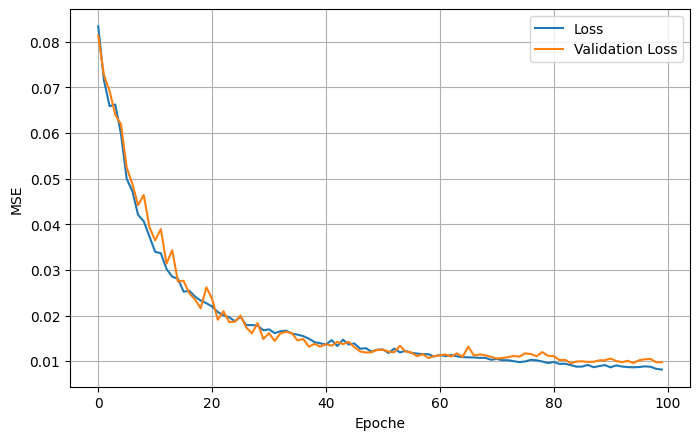

In [10]:
dnn_model_9494000 = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(64,(2,2),strides=2,input_shape=(days,57,67,5))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(4)),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32,(2,2),strides=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(units=30,dropout=0.2,return_sequences=True),
    tf.keras.layers.LSTM(units=10,dropout=0.1),
    tf.keras.layers.Dense(units=1)
])

history = kompilierung(model=dnn_model_9494000, inputs=forcings_9494000_train, targets=streamflow_9494000_train,
                          validation=(forcings_9494000_eval, streamflow_9494000_eval), batch_size=64, epochs=100)

loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_9494000 = dnn_model_9494000.evaluate(forcings_9494000_test, streamflow_9494000_test)
# Vorhersage der auf den Testdaten
y_predicted_9494000 = dnn_model_9494000.predict(forcings_9494000_test)


### Eureka CNNLSTM

Epoch 1/100
63/63 [==============================] - 20s 324ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - mean_absolute_error: 0.1939 - val_loss: 0.0538 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1648
Epoch 2/100
63/63 [==============================] - 21s 336ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1623 - val_loss: 0.0409 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1498
Epoch 3/100
63/63 [==============================] - 29s 468ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1525 - val_loss: 0.0416 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1651
Epoch 4/100
63/63 [==============================] - 16s 249ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1409 - val_loss: 0.0300 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1380
Epoch 5/100
63/63 [==============================] - 12s 189ms/step - loss: 0.0309 - mea

Epoch 37/100
63/63 [==============================] - 15s 242ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0729 - val_loss: 0.0113 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0690
Epoch 38/100
63/63 [==============================] - 18s 280ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0721 - val_loss: 0.0107 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0686
Epoch 39/100
63/63 [==============================] - 15s 235ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0712 - val_loss: 0.0120 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0721
Epoch 40/100
63/63 [==============================] - 11s 179ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0707 - val_loss: 0.0124 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0744
Epoch 41/100
63/63 [==============================] - 11s 181ms/step - loss: 0.0106 

Epoch 73/100
63/63 [==============================] - 12s 187ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0585 - val_loss: 0.0097 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0592
Epoch 74/100
63/63 [==============================] - 23s 363ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0603 - val_loss: 0.0106 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0642
Epoch 75/100
63/63 [==============================] - 13s 205ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0637 - val_loss: 0.0096 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0614
Epoch 76/100
63/63 [==============================] - 20s 323ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0583 - val_loss: 0.0091 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0587
Epoch 77/100
63/63 [==============================] - 13s 211ms/step - loss: 0.0070 

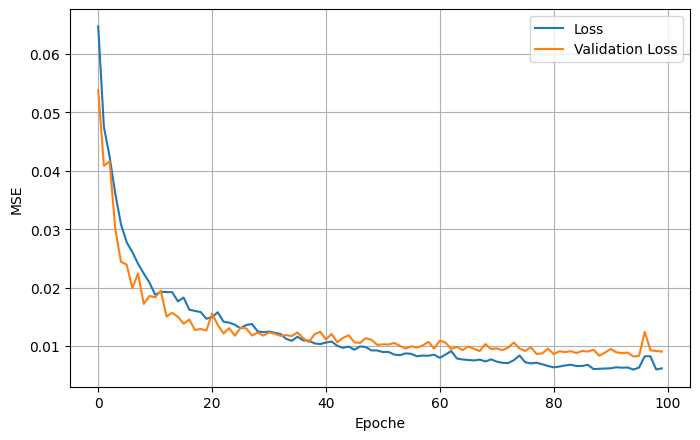

In [27]:
dnn_model_11522500 = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(64,(3,3),strides=2,input_shape=(days,73,64,5))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(4)),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32,(2,2),strides=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(units=30,dropout=0.2,return_sequences=True),
    tf.keras.layers.LSTM(units=10,dropout=0.1),
    tf.keras.layers.Dense(units=1)
])

history = kompilierung(model=dnn_model_11522500, inputs=forcings_11522500_train, targets=streamflow_11522500_train,
                          validation=(forcings_11522500_eval, streamflow_11522500_eval), batch_size=64, epochs=100)

loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_11522500 = dnn_model_11522500.evaluate(forcings_11522500_test, streamflow_11522500_test)
# Vorhersage der auf den Testdaten
y_predicted_11522500 = dnn_model_11522500.predict(forcings_11522500_test)

### Seattle CNNLSTM

Epoch 1/100
63/63 [==============================] - 25s 402ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - mean_absolute_error: 0.2217 - val_loss: 0.0646 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.2126
Epoch 2/100
63/63 [==============================] - 16s 251ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1977 - val_loss: 0.0606 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1934
Epoch 3/100
63/63 [==============================] - 17s 265ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1841 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1870
Epoch 4/100
63/63 [==============================] - 18s 291ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1761 - val_loss: 0.0489 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1774
Epoch 5/100
63/63 [==============================] - 13s 202ms/step - loss: 0.0509 - mea

Epoch 37/100
63/63 [==============================] - 9s 136ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0934 - val_loss: 0.0165 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0920
Epoch 38/100
63/63 [==============================] - 9s 138ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0927 - val_loss: 0.0164 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0884
Epoch 39/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0955 - val_loss: 0.0181 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0941
Epoch 40/100
63/63 [==============================] - 9s 136ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0947 - val_loss: 0.0168 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0902
Epoch 41/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0162 - mea

Epoch 73/100
63/63 [==============================] - 9s 136ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0773 - val_loss: 0.0142 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0803
Epoch 74/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0767 - val_loss: 0.0159 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0829
Epoch 75/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0778 - val_loss: 0.0153 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0835
Epoch 76/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0776 - val_loss: 0.0158 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0868
Epoch 77/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0113 - mea

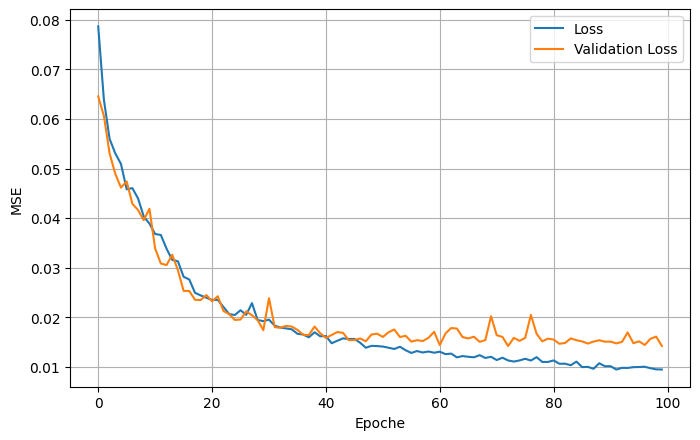

In [52]:
dnn_model_12189500 = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(64,(3,3),strides=2,input_shape=(timesteps,x_shape,y_shape,features))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(4)),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32,(2,2),strides=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(units=30,dropout=0.2,return_sequences=True),
    tf.keras.layers.LSTM(units=10,dropout=0.1),
    tf.keras.layers.Dense(units=1)
])

history = kompilierung(model=dnn_model_12189500, inputs=forcings_12189500_train, targets=streamflow_12189500_train,
                          validation=(forcings_12189500_eval, streamflow_12189500_eval), batch_size=64, epochs=100)

loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_12189500 = dnn_model_12189500.evaluate(forcings_12189500_test, streamflow_12189500_test)
# Vorhersage der auf den Testdaten
y_predicted_12189500 = dnn_model_12189500.predict(forcings_12189500_test)


### Datenvorbereitung LSTM

In [63]:
basin = ["09494000","11522500","12189500"]
days=50
forcing=[]
streamflow=[]
for i in basin:
    forcings_path = "./data/{}_lump_cida_forcing_leap.txt".format(i)
    streamflow_path = "./data/{}_streamflow_qc.txt".format(i)
    # Initialisierung der Daten
    df_forcings = dataio.load_forcings(forcings_path)
    #df_forcings.drop(['swe(mm)','dayl(s)','srad(W/m2)','tmax(C)','tmin(C)','vp(Pa)'], inplace=True, axis=1)
    df_forcings.drop(['swe(mm)','dayl(s)'], inplace=True, axis=1)
    forcings = df_forcings["1980-01":"1995-12"]
    df_streamflow = dataio.load_streamflow(streamflow_path)
    df_streamflow['streamflow']=df_streamflow['streamflow']*0.028316846592
    df_streamflow.drop(['qc_flag','gauge_id'], inplace=True, axis=1)
    streamflows = df_streamflow["1980-02-20":"1996-02-19"].to_numpy()
    print(streamflows)
    forcing.append(forcings)
    streamflow.append(streamflows)

    
# Normierung
forcing_LSTM_9494000, SF_LSTM_forcing_9494000 = scale(forcing[0])
streamflow_LSTM_9494000, SF_LSTM_streamflow_9494000 = scale(streamflow[0])
forcing_LSTM_9494000,streamflow_LSTM_9494000 = prepareTensor(forcing_LSTM_9494000,streamflow_LSTM_9494000,days)

forcing_LSTM_9494000,streamflow_LSTM_9494000 = shuffle(forcing_LSTM_9494000,streamflow_LSTM_9494000)
forcing_LSTM_11522500, SF_LSTM_forcing_11522500 = scale(forcing[1])
streamflow_LSTM_11522500, SF_LSTM_streamflow_11522500 = scale(streamflow[1])
forcing_LSTM_11522500,streamflow_LSTM_11522500 = prepareTensor(forcing_LSTM_11522500,streamflow_LSTM_11522500,days)
forcing_LSTM_11522500,streamflow_LSTM_11522500 = shuffle(forcing_LSTM_11522500,streamflow_LSTM_11522500)

forcing_LSTM_12189500, SF_LSTM_forcing_12189500 = scale(forcing[2])
streamflow_LSTM_12189500, SF_LSTM_streamflow_12189500 = scale(streamflow[2])
forcing_LSTM_12189500,streamflow_LSTM_12189500 = prepareTensor(forcing_LSTM_12189500,streamflow_LSTM_12189500,days)
forcing_LSTM_12189500,streamflow_LSTM_12189500 = shuffle(forcing_LSTM_12189500,streamflow_LSTM_12189500)

# Trainingsdaten
forcing_LSTM_9494000_train = forcing_LSTM_9494000[:round(len(forcing_LSTM_9494000)*0.8)]
streamflow_LSTM_9494000_train = streamflow_LSTM_9494000[:round(len(streamflow_LSTM_9494000)*0.8)]

forcing_LSTM_11522500_train = forcing_LSTM_11522500[:round(len(forcing_LSTM_11522500)*0.8)]
streamflow_LSTM_11522500_train = streamflow_LSTM_11522500[:round(len(streamflow_LSTM_11522500)*0.8)]

forcing_LSTM_12189500_train = forcing_LSTM_12189500[:round(len(forcing_LSTM_12189500)*0.8)]
streamflow_LSTM_12189500_train = streamflow_LSTM_12189500[:round(len(streamflow_LSTM_12189500)*0.8)]

# Evaluierungsdaten
forcing_LSTM_9494000_eval= forcing_LSTM_9494000[round(len(forcing_LSTM_9494000)*0.8):round(len(forcing_LSTM_9494000)*0.9)]
streamflow_LSTM_9494000_eval= streamflow_LSTM_9494000[round(len(streamflow_LSTM_9494000)*0.8):round(len(streamflow_LSTM_9494000)*0.9)]

forcing_LSTM_11522500_eval= forcing_LSTM_11522500[round(len(forcing_LSTM_11522500)*0.8):round(len(forcing_LSTM_11522500)*0.9)]
streamflow_LSTM_11522500_eval= streamflow_LSTM_11522500[round(len(streamflow_LSTM_11522500)*0.8):round(len(streamflow_LSTM_11522500)*0.9)]

forcing_LSTM_12189500_eval= forcing_LSTM_12189500[round(len(forcing_LSTM_12189500)*0.8):round(len(forcing_LSTM_12189500)*0.9)]
streamflow_LSTM_12189500_eval= streamflow_LSTM_12189500[round(len(streamflow_LSTM_12189500)*0.8):round(len(streamflow_LSTM_12189500)*0.9)]

# Testdaten
forcing_LSTM_9494000_test= forcing_LSTM_9494000[round(len(forcing_LSTM_9494000)*0.9):]
streamflow_LSTM_9494000_test= streamflow_LSTM_9494000[round(len(streamflow_LSTM_9494000)*0.9):]

forcing_LSTM_11522500_test= forcing_LSTM_11522500[round(len(forcing_LSTM_11522500)*0.9):]
streamflow_LSTM_11522500_test= streamflow_LSTM_11522500[round(len(streamflow_LSTM_11522500)*0.9):]

forcing_LSTM_12189500_test= forcing_LSTM_12189500[round(len(forcing_LSTM_12189500)*0.9):]
streamflow_LSTM_12189500_test= streamflow_LSTM_12189500[round(len(streamflow_LSTM_12189500)*0.9):]


[[77.3049912 ]
 [41.90893296]
 [36.24556364]
 ...
 [ 1.75564449]
 [ 1.81227818]
 [ 1.78396134]]
[[152.34463466]
 [132.23967358]
 [112.70104944]
 ...
 [190.85554603]
 [213.79219177]
 [220.87140342]]
[[100.24163694]
 [ 86.08321364]
 [ 75.6059804 ]
 ...
 [178.39613353]
 [305.82194319]
 [274.10707501]]


### Mesa LSTM

Epoch 1/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0268 - val_loss: 0.0014 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0287
Epoch 2/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0205 - val_loss: 0.0012 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0203
Epoch 3/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0201 - val_loss: 0.0010 - val_mean_squared_error: 9.5706e-04 - val_mean_absolute_error: 0.0172
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0199 - val_loss: 0.0012 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0186
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0014 - mean_squared_

Epoch 36/200
73/73 [==============================] - 1s 8ms/step - loss: 7.9331e-04 - mean_squared_error: 8.0546e-04 - mean_absolute_error: 0.0142 - val_loss: 5.6067e-04 - val_mean_squared_error: 5.2200e-04 - val_mean_absolute_error: 0.0137
Epoch 37/200
73/73 [==============================] - 1s 8ms/step - loss: 7.8389e-04 - mean_squared_error: 7.7973e-04 - mean_absolute_error: 0.0142 - val_loss: 9.6052e-04 - val_mean_squared_error: 8.8932e-04 - val_mean_absolute_error: 0.0169
Epoch 38/200
73/73 [==============================] - 1s 8ms/step - loss: 7.8823e-04 - mean_squared_error: 7.8601e-04 - mean_absolute_error: 0.0144 - val_loss: 6.3951e-04 - val_mean_squared_error: 5.8655e-04 - val_mean_absolute_error: 0.0150
Epoch 39/200
73/73 [==============================] - 1s 8ms/step - loss: 7.7812e-04 - mean_squared_error: 7.7476e-04 - mean_absolute_error: 0.0142 - val_loss: 6.3763e-04 - val_mean_squared_error: 5.7952e-04 - val_mean_absolute_error: 0.0145
Epoch 40/200
73/73 [============

Epoch 70/200
73/73 [==============================] - 1s 8ms/step - loss: 3.9156e-04 - mean_squared_error: 3.8997e-04 - mean_absolute_error: 0.0110 - val_loss: 3.9946e-04 - val_mean_squared_error: 4.0086e-04 - val_mean_absolute_error: 0.0113
Epoch 71/200
73/73 [==============================] - 1s 8ms/step - loss: 4.3369e-04 - mean_squared_error: 4.3293e-04 - mean_absolute_error: 0.0112 - val_loss: 4.1634e-04 - val_mean_squared_error: 4.2717e-04 - val_mean_absolute_error: 0.0126
Epoch 72/200
73/73 [==============================] - 1s 8ms/step - loss: 4.6923e-04 - mean_squared_error: 4.6826e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0010 - val_mean_squared_error: 9.5450e-04 - val_mean_absolute_error: 0.0180
Epoch 73/200
73/73 [==============================] - 1s 8ms/step - loss: 4.7374e-04 - mean_squared_error: 4.7318e-04 - mean_absolute_error: 0.0124 - val_loss: 4.0187e-04 - val_mean_squared_error: 3.7975e-04 - val_mean_absolute_error: 0.0113
Epoch 74/200
73/73 [================

Epoch 104/200
73/73 [==============================] - 1s 8ms/step - loss: 4.0763e-04 - mean_squared_error: 4.0891e-04 - mean_absolute_error: 0.0113 - val_loss: 4.5873e-04 - val_mean_squared_error: 4.4890e-04 - val_mean_absolute_error: 0.0127
Epoch 105/200
73/73 [==============================] - 1s 8ms/step - loss: 3.1289e-04 - mean_squared_error: 3.1108e-04 - mean_absolute_error: 0.0102 - val_loss: 3.0184e-04 - val_mean_squared_error: 3.1505e-04 - val_mean_absolute_error: 0.0103
Epoch 106/200
73/73 [==============================] - 1s 8ms/step - loss: 2.7883e-04 - mean_squared_error: 2.7831e-04 - mean_absolute_error: 0.0096 - val_loss: 2.8295e-04 - val_mean_squared_error: 2.8701e-04 - val_mean_absolute_error: 0.0101
Epoch 107/200
73/73 [==============================] - 1s 8ms/step - loss: 2.9445e-04 - mean_squared_error: 2.9293e-04 - mean_absolute_error: 0.0097 - val_loss: 3.8800e-04 - val_mean_squared_error: 4.1666e-04 - val_mean_absolute_error: 0.0114
Epoch 108/200
73/73 [=======

Epoch 138/200
73/73 [==============================] - 1s 8ms/step - loss: 1.5312e-04 - mean_squared_error: 1.5466e-04 - mean_absolute_error: 0.0072 - val_loss: 3.0928e-04 - val_mean_squared_error: 3.0120e-04 - val_mean_absolute_error: 0.0098
Epoch 139/200
73/73 [==============================] - 1s 8ms/step - loss: 1.4765e-04 - mean_squared_error: 1.4728e-04 - mean_absolute_error: 0.0072 - val_loss: 2.8081e-04 - val_mean_squared_error: 2.6136e-04 - val_mean_absolute_error: 0.0086
Epoch 140/200
73/73 [==============================] - 1s 8ms/step - loss: 1.7215e-04 - mean_squared_error: 1.7393e-04 - mean_absolute_error: 0.0076 - val_loss: 3.2792e-04 - val_mean_squared_error: 3.1954e-04 - val_mean_absolute_error: 0.0110
Epoch 141/200
73/73 [==============================] - 1s 8ms/step - loss: 4.2807e-04 - mean_squared_error: 4.3170e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0011 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0176
Epoch 142/200
73/73 [===============

Epoch 172/200
73/73 [==============================] - 1s 8ms/step - loss: 2.7978e-04 - mean_squared_error: 2.8083e-04 - mean_absolute_error: 0.0103 - val_loss: 3.8451e-04 - val_mean_squared_error: 3.6004e-04 - val_mean_absolute_error: 0.0102
Epoch 173/200
73/73 [==============================] - 1s 8ms/step - loss: 1.5596e-04 - mean_squared_error: 1.5532e-04 - mean_absolute_error: 0.0076 - val_loss: 4.7856e-04 - val_mean_squared_error: 4.4389e-04 - val_mean_absolute_error: 0.0088
Epoch 174/200
73/73 [==============================] - 1s 8ms/step - loss: 1.3434e-04 - mean_squared_error: 1.3392e-04 - mean_absolute_error: 0.0069 - val_loss: 3.9031e-04 - val_mean_squared_error: 3.6573e-04 - val_mean_absolute_error: 0.0087
Epoch 175/200
73/73 [==============================] - 1s 8ms/step - loss: 9.6155e-05 - mean_squared_error: 9.7196e-05 - mean_absolute_error: 0.0062 - val_loss: 2.5656e-04 - val_mean_squared_error: 2.4159e-04 - val_mean_absolute_error: 0.0085
Epoch 176/200
73/73 [=======

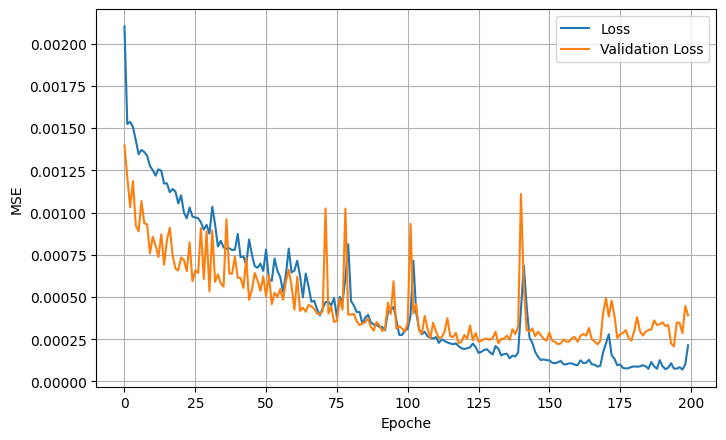

In [82]:
dnn_model_LSTM_9494000 = tf.keras.Sequential([
    tf.keras.layers.LSTM(50,  input_shape=(50,5), return_sequences=True),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])

# Bauen und Trainieren des NNs
history = kompilierung(model=dnn_model_LSTM_9494000, inputs=forcing_LSTM_9494000_train, targets=streamflow_LSTM_9494000_train,
                          validation=(forcing_LSTM_9494000_eval, streamflow_LSTM_9494000_eval), batch_size=64, epochs=200)

loss(history)


# Evaluierung und Speichern der Metriken
result_9494000_LSTM = dnn_model_LSTM_9494000.evaluate(forcing_LSTM_9494000_test, streamflow_LSTM_9494000_test)
# Vorhersage der auf den Testdaten
y_predicted_9494000_LSTM = dnn_model_LSTM_9494000.predict(forcing_LSTM_9494000_test)

### Eureka LSTM

Epoch 1/200
73/73 [==============================] - 2s 21ms/step - loss: 0.0053 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0439 - val_loss: 0.0030 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0330
Epoch 2/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0333 - val_loss: 0.0025 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0262
Epoch 3/200
73/73 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0298 - val_loss: 0.0026 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0295
Epoch 4/200
73/73 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0298 - val_loss: 0.0024 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0232
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_squared_er

73/73 [==============================] - 1s 8ms/step - loss: 8.6451e-04 - mean_squared_error: 8.6322e-04 - mean_absolute_error: 0.0163 - val_loss: 9.9366e-04 - val_mean_squared_error: 9.0885e-04 - val_mean_absolute_error: 0.0170
Epoch 73/200
73/73 [==============================] - 1s 8ms/step - loss: 9.1618e-04 - mean_squared_error: 9.1274e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0011 - val_mean_squared_error: 9.7838e-04 - val_mean_absolute_error: 0.0158
Epoch 74/200
73/73 [==============================] - 1s 9ms/step - loss: 8.0285e-04 - mean_squared_error: 7.9852e-04 - mean_absolute_error: 0.0156 - val_loss: 9.8129e-04 - val_mean_squared_error: 9.0120e-04 - val_mean_absolute_error: 0.0184
Epoch 75/200
73/73 [==============================] - 1s 8ms/step - loss: 7.7606e-04 - mean_squared_error: 7.8273e-04 - mean_absolute_error: 0.0153 - val_loss: 9.5248e-04 - val_mean_squared_error: 8.6672e-04 - val_mean_absolute_error: 0.0174
Epoch 76/200
73/73 [=============================

73/73 [==============================] - 1s 8ms/step - loss: 5.5730e-04 - mean_squared_error: 5.5512e-04 - mean_absolute_error: 0.0128 - val_loss: 8.5679e-04 - val_mean_squared_error: 7.8296e-04 - val_mean_absolute_error: 0.0150
Epoch 107/200
73/73 [==============================] - 1s 8ms/step - loss: 4.9699e-04 - mean_squared_error: 4.9517e-04 - mean_absolute_error: 0.0124 - val_loss: 8.5348e-04 - val_mean_squared_error: 7.8902e-04 - val_mean_absolute_error: 0.0145
Epoch 108/200
73/73 [==============================] - 1s 8ms/step - loss: 5.6469e-04 - mean_squared_error: 5.6354e-04 - mean_absolute_error: 0.0131 - val_loss: 7.8389e-04 - val_mean_squared_error: 7.3006e-04 - val_mean_absolute_error: 0.0142
Epoch 109/200
73/73 [==============================] - 1s 8ms/step - loss: 5.0125e-04 - mean_squared_error: 5.0021e-04 - mean_absolute_error: 0.0121 - val_loss: 8.4519e-04 - val_mean_squared_error: 7.7163e-04 - val_mean_absolute_error: 0.0174
Epoch 110/200
73/73 [=====================

Epoch 140/200
73/73 [==============================] - 1s 8ms/step - loss: 3.3896e-04 - mean_squared_error: 3.3937e-04 - mean_absolute_error: 0.0102 - val_loss: 7.4555e-04 - val_mean_squared_error: 6.8562e-04 - val_mean_absolute_error: 0.0130
Epoch 141/200
73/73 [==============================] - 1s 8ms/step - loss: 3.3760e-04 - mean_squared_error: 3.3608e-04 - mean_absolute_error: 0.0103 - val_loss: 9.4167e-04 - val_mean_squared_error: 8.6918e-04 - val_mean_absolute_error: 0.0138
Epoch 142/200
73/73 [==============================] - 1s 8ms/step - loss: 3.7578e-04 - mean_squared_error: 3.7500e-04 - mean_absolute_error: 0.0108 - val_loss: 7.5707e-04 - val_mean_squared_error: 6.9180e-04 - val_mean_absolute_error: 0.0131
Epoch 143/200
73/73 [==============================] - 1s 8ms/step - loss: 3.6042e-04 - mean_squared_error: 3.5989e-04 - mean_absolute_error: 0.0106 - val_loss: 6.4755e-04 - val_mean_squared_error: 5.8950e-04 - val_mean_absolute_error: 0.0129
Epoch 144/200
73/73 [=======

Epoch 174/200
73/73 [==============================] - 1s 8ms/step - loss: 2.7769e-04 - mean_squared_error: 2.7911e-04 - mean_absolute_error: 0.0095 - val_loss: 8.2135e-04 - val_mean_squared_error: 7.4866e-04 - val_mean_absolute_error: 0.0125
Epoch 175/200
73/73 [==============================] - 1s 8ms/step - loss: 2.7704e-04 - mean_squared_error: 2.7647e-04 - mean_absolute_error: 0.0096 - val_loss: 7.4158e-04 - val_mean_squared_error: 6.7678e-04 - val_mean_absolute_error: 0.0132
Epoch 176/200
73/73 [==============================] - 1s 8ms/step - loss: 2.2769e-04 - mean_squared_error: 2.2691e-04 - mean_absolute_error: 0.0087 - val_loss: 6.5545e-04 - val_mean_squared_error: 6.0294e-04 - val_mean_absolute_error: 0.0115
Epoch 177/200
73/73 [==============================] - 1s 8ms/step - loss: 2.5551e-04 - mean_squared_error: 2.5521e-04 - mean_absolute_error: 0.0092 - val_loss: 8.2124e-04 - val_mean_squared_error: 7.4678e-04 - val_mean_absolute_error: 0.0127
Epoch 178/200
73/73 [=======

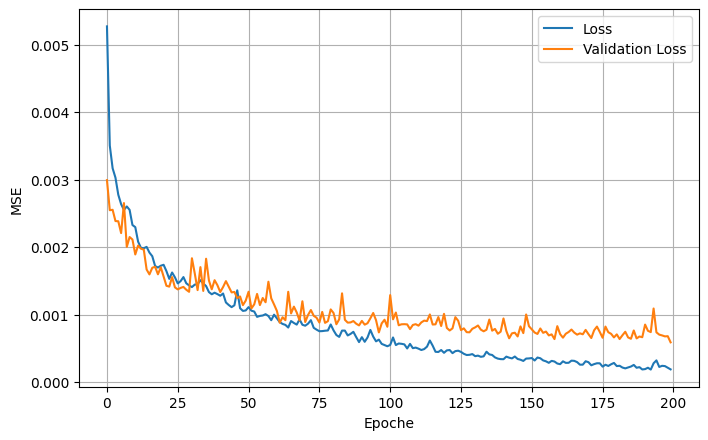

In [83]:
dnn_model_LSTM_11522500 = tf.keras.Sequential([
    tf.keras.layers.LSTM(50,  input_shape=(50,5), return_sequences=True),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])

# Bauen und Trainieren des NNs
history = kompilierung(model=dnn_model_LSTM_11522500, inputs=forcing_LSTM_11522500_train, targets=streamflow_LSTM_11522500_train,
                          validation=(forcing_LSTM_11522500_eval, streamflow_LSTM_11522500_eval), batch_size=64, epochs=200)

loss(history)


# Evaluierung und Speichern der Metriken
result_11522500_LSTM = dnn_model_LSTM_11522500.evaluate(forcing_LSTM_11522500_test, streamflow_LSTM_11522500_test)
# Vorhersage der auf den Testdaten
y_predicted_11522500_LSTM = dnn_model_LSTM_11522500.predict(forcing_LSTM_11522500_test)


### Seattle LSTM

Epoch 1/200
73/73 [==============================] - 1s 19ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0335 - val_loss: 0.0023 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0273
Epoch 2/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0266 - val_loss: 0.0020 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0233
Epoch 3/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0248 - val_loss: 0.0018 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0215
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0234 - val_loss: 0.0015 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0205
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_squared_erro

Epoch 70/200
73/73 [==============================] - 1s 8ms/step - loss: 6.4204e-04 - mean_squared_error: 6.3926e-04 - mean_absolute_error: 0.0141 - val_loss: 6.3626e-04 - val_mean_squared_error: 5.9567e-04 - val_mean_absolute_error: 0.0144
Epoch 71/200
73/73 [==============================] - 1s 8ms/step - loss: 6.2039e-04 - mean_squared_error: 6.1707e-04 - mean_absolute_error: 0.0141 - val_loss: 7.1802e-04 - val_mean_squared_error: 6.7151e-04 - val_mean_absolute_error: 0.0158
Epoch 72/200
73/73 [==============================] - 1s 8ms/step - loss: 6.7762e-04 - mean_squared_error: 6.7458e-04 - mean_absolute_error: 0.0142 - val_loss: 8.4218e-04 - val_mean_squared_error: 7.7399e-04 - val_mean_absolute_error: 0.0156
Epoch 73/200
73/73 [==============================] - 1s 8ms/step - loss: 7.0787e-04 - mean_squared_error: 7.0524e-04 - mean_absolute_error: 0.0146 - val_loss: 6.6617e-04 - val_mean_squared_error: 6.3668e-04 - val_mean_absolute_error: 0.0158
Epoch 74/200
73/73 [============

Epoch 104/200
73/73 [==============================] - 1s 7ms/step - loss: 5.1853e-04 - mean_squared_error: 5.2203e-04 - mean_absolute_error: 0.0132 - val_loss: 6.7020e-04 - val_mean_squared_error: 6.2643e-04 - val_mean_absolute_error: 0.0161
Epoch 105/200
73/73 [==============================] - 1s 8ms/step - loss: 4.4223e-04 - mean_squared_error: 4.4074e-04 - mean_absolute_error: 0.0130 - val_loss: 7.2918e-04 - val_mean_squared_error: 6.8003e-04 - val_mean_absolute_error: 0.0150
Epoch 106/200
73/73 [==============================] - 1s 8ms/step - loss: 4.0499e-04 - mean_squared_error: 4.0915e-04 - mean_absolute_error: 0.0122 - val_loss: 7.2967e-04 - val_mean_squared_error: 6.7043e-04 - val_mean_absolute_error: 0.0154
Epoch 107/200
73/73 [==============================] - 1s 8ms/step - loss: 4.9477e-04 - mean_squared_error: 4.9398e-04 - mean_absolute_error: 0.0131 - val_loss: 7.6357e-04 - val_mean_squared_error: 6.9350e-04 - val_mean_absolute_error: 0.0144
Epoch 108/200
73/73 [=======

Epoch 138/200
73/73 [==============================] - 1s 8ms/step - loss: 3.0306e-04 - mean_squared_error: 3.0250e-04 - mean_absolute_error: 0.0109 - val_loss: 6.1960e-04 - val_mean_squared_error: 5.7008e-04 - val_mean_absolute_error: 0.0132
Epoch 139/200
73/73 [==============================] - 1s 7ms/step - loss: 2.9429e-04 - mean_squared_error: 2.9252e-04 - mean_absolute_error: 0.0109 - val_loss: 7.0726e-04 - val_mean_squared_error: 6.4840e-04 - val_mean_absolute_error: 0.0140
Epoch 140/200
73/73 [==============================] - 1s 8ms/step - loss: 3.0194e-04 - mean_squared_error: 3.0286e-04 - mean_absolute_error: 0.0110 - val_loss: 6.1373e-04 - val_mean_squared_error: 5.6297e-04 - val_mean_absolute_error: 0.0132
Epoch 141/200
73/73 [==============================] - 1s 8ms/step - loss: 2.9654e-04 - mean_squared_error: 2.9625e-04 - mean_absolute_error: 0.0109 - val_loss: 6.5536e-04 - val_mean_squared_error: 6.0462e-04 - val_mean_absolute_error: 0.0135
Epoch 142/200
73/73 [=======

Epoch 172/200
73/73 [==============================] - 1s 8ms/step - loss: 2.4071e-04 - mean_squared_error: 2.3962e-04 - mean_absolute_error: 0.0100 - val_loss: 6.5270e-04 - val_mean_squared_error: 5.9576e-04 - val_mean_absolute_error: 0.0118
Epoch 173/200
73/73 [==============================] - 1s 7ms/step - loss: 2.1632e-04 - mean_squared_error: 2.1565e-04 - mean_absolute_error: 0.0095 - val_loss: 6.7278e-04 - val_mean_squared_error: 6.1803e-04 - val_mean_absolute_error: 0.0122
Epoch 174/200
73/73 [==============================] - 1s 7ms/step - loss: 2.2292e-04 - mean_squared_error: 2.2333e-04 - mean_absolute_error: 0.0097 - val_loss: 5.9291e-04 - val_mean_squared_error: 5.4814e-04 - val_mean_absolute_error: 0.0135
Epoch 175/200
73/73 [==============================] - 1s 7ms/step - loss: 2.3988e-04 - mean_squared_error: 2.3844e-04 - mean_absolute_error: 0.0100 - val_loss: 6.3274e-04 - val_mean_squared_error: 5.8820e-04 - val_mean_absolute_error: 0.0127
Epoch 176/200
73/73 [=======

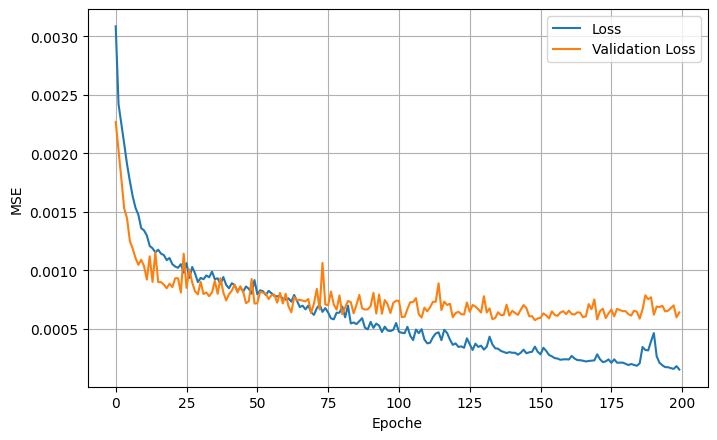

In [86]:
dnn_model_LSTM_12189500 = tf.keras.Sequential([
    tf.keras.layers.LSTM(50,  input_shape=(timesteps,features), return_sequences=True),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])

# Bauen und Trainieren des NNs
history = kompilierung(model=dnn_model_LSTM_12189500, inputs=forcing_LSTM_12189500_train, targets=streamflow_LSTM_12189500_train,
                          validation=(forcing_LSTM_12189500_eval, streamflow_LSTM_12189500_eval), batch_size=64, epochs=200)

loss(history)


# Evaluierung und Speichern der Metriken
result_12189500_LSTM = dnn_model_LSTM_12189500.evaluate(forcing_LSTM_12189500_test, streamflow_LSTM_12189500_test)
# Vorhersage der auf den Testdaten
y_predicted_12189500_LSTM = dnn_model_LSTM_12189500.predict(forcing_LSTM_12189500_test)


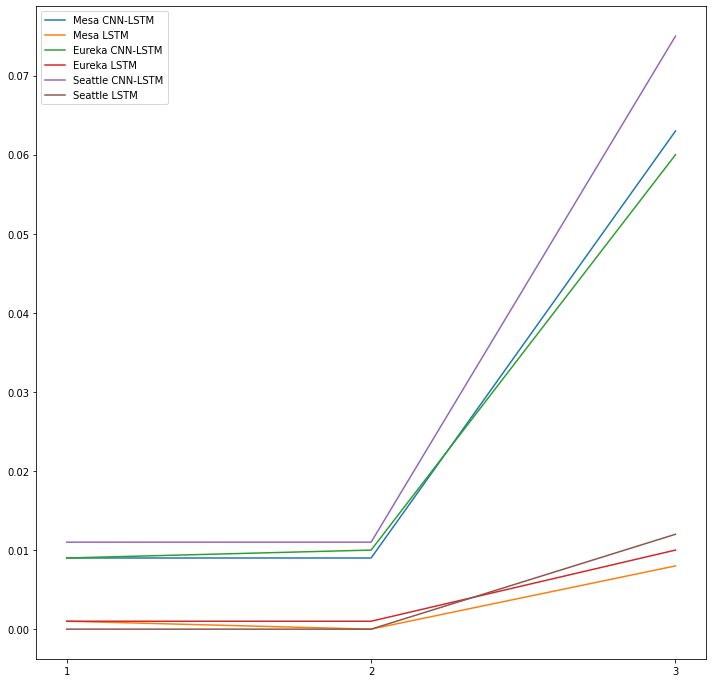

In [68]:
index=["Mesa CNN-LSTM","Mesa LSTM","Eureka CNN-LSTM","Eureka LSTM","Seattle CNN-LSTM","Seattle LSTM"]
results = [dnn_results_9494000,result_9494000_LSTM,dnn_results_11522500,result_11522500_LSTM,dnn_results_12189500,result_12189500_LSTM]

df = pd.DataFrame(results,index=index)

x1=[]
x2=[]
x3=[]
for i in df[0]:
    x1.append(round(i,3))
for i in df[1]:
    x2.append(round(i,3))
for i in df[2]:
    x3.append(round(i,3))
    
fig, ax = plt.subplots(figsize=(12,12))
counter=0
while counter<len(x1):
    plt.plot([1,2,3],[x1[counter],x2[counter],x3[counter]],label=index[counter])
    counter+=1
ax.legend()
plt.xticks([1,2,3])
plt.show()

Text(0, 0.5, 'NSE')

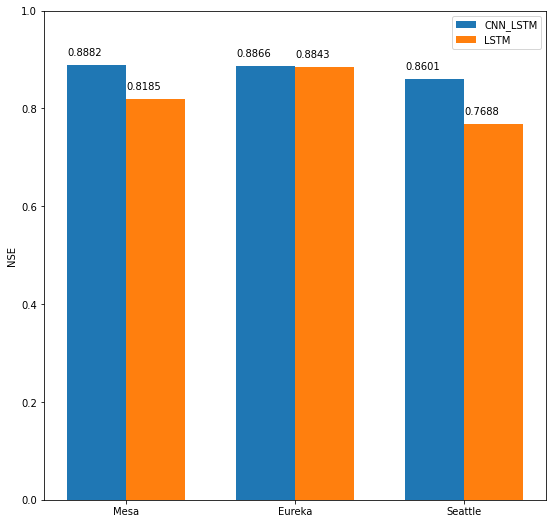

In [78]:
# NSE Berechnung
index=["Mesa","Eureka","Seattle"]
def nse(ypred, ytest):
    zahlersum=[]
    nennersum=[]
    qo=np.sum(ytest)/len(ytest)
    counter=0
    while counter < len(ypred):
        zahler = (ypred[counter][0]-ytest[counter])**2
        zahlersum.append(zahler)
        nenner = (ytest[counter]-qo)**2
        nennersum.append(nenner)
        counter+=1
    zahlersum = np.sum(zahlersum)
    nennersum = np.sum(nennersum)
    nse = 1 - (zahlersum/nennersum)
    return nse
# CNNLSTM NSE
y_predicted_9494000_shaped=np.reshape(y_predicted_9494000,(y_predicted_9494000.shape[0],y_predicted_9494000.shape[1]))
nse_9494000 = nse(y_predicted_9494000_shaped, streamflow_9494000_test)

y_predicted_11522500_shaped=np.reshape(y_predicted_11522500,(y_predicted_11522500.shape[0],y_predicted_11522500.shape[1]))
nse_11522500 = nse(y_predicted_11522500_shaped, streamflow_11522500_test)

y_predicted_12189500_shaped=np.reshape(y_predicted_12189500,(y_predicted_12189500.shape[0],y_predicted_12189500.shape[1]))
nse_12189500 = nse(y_predicted_12189500_shaped, streamflow_12189500_test)

# LSTM NSE
nse_9494000_LSTM = nse(y_predicted_9494000_LSTM, streamflow_LSTM_9494000_test)
nse_11522500_LSTM= nse(y_predicted_11522500_LSTM, streamflow_LSTM_11522500_test)
nse_12189500_LSTM = nse(y_predicted_12189500_LSTM, streamflow_LSTM_12189500_test)

nse_CNNLSTM = [nse_9494000,nse_11522500,nse_12189500]
nse_LSTM=[nse_9494000_LSTM,nse_11522500_LSTM,nse_12189500_LSTM]
x = np.arange(len(index)) 
width = 0.35 
fig, ax = plt.subplots(figsize=(9,9))
ax.bar(x , nse_CNNLSTM, width, label='CNN_LSTM')
ax.bar(x+width , nse_LSTM, width, label='LSTM')
ax.set_xticks(x+width/2)
ax.set_xticklabels(index)
plt.ylim(0,1)
for ind, value in enumerate(nse_CNNLSTM):
    plt.text(ind-width/2, value+0.02, str(round(value,4)))
for ind, value in enumerate(nse_LSTM):
    plt.text(ind+width/2, value+0.02, str(round(value,4)))
ax.legend()
plt.ylabel('NSE')

(504, 1)
(579, 1)


(<matplotlib.legend.Legend at 0x1f2393eb790>, Text(0.5, 1.0, 'Seattle_LSTM'))

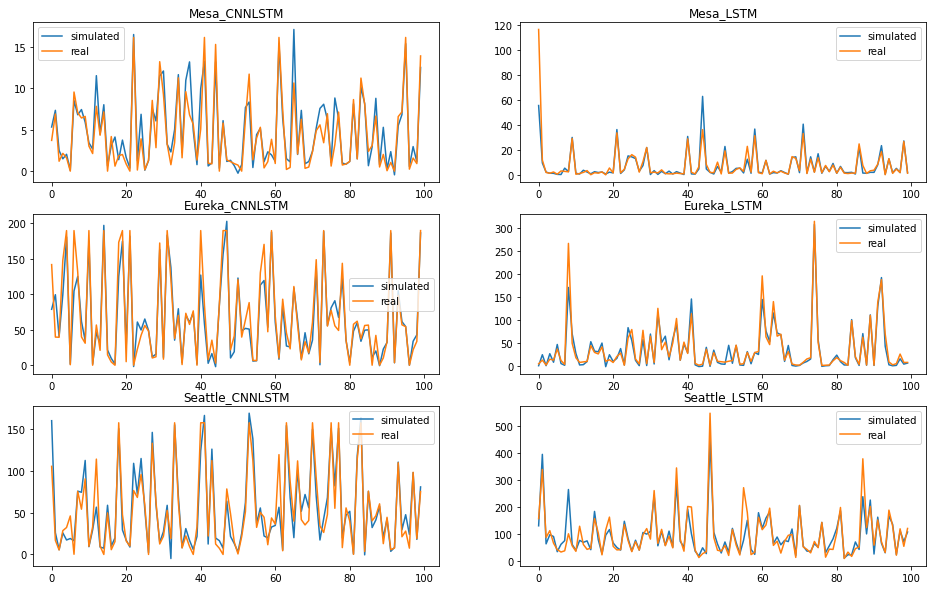

In [70]:
#CNNLSTM
y_9494000_simulated_real=y_predicted_9494000*SF_streamflow_9494000[0]
streamflow_9494000_test_real=streamflow_9494000_test*SF_streamflow_9494000[0]
y_11522500_simulated_real=y_predicted_11522500*SF_streamflow_11522500[0]
streamflow_11522500_test_real=streamflow_11522500_test*SF_streamflow_11522500[0]
y_12189500_simulated_real=y_predicted_12189500*SF_streamflow_12189500[0]
streamflow_12189500_test_real=streamflow_12189500_test*SF_streamflow_12189500[0]
print(y_9494000_simulated_real.shape)
#LSTM
y_9494000_LSTM_simulated=y_predicted_9494000_LSTM*SF_LSTM_streamflow_9494000
y_11522500_LSTM_simulated=y_predicted_11522500_LSTM*SF_LSTM_streamflow_11522500
y_12189500_LSTM_simulated=y_predicted_12189500_LSTM*SF_LSTM_streamflow_12189500
y_9494000_LSTM_real=streamflow_LSTM_9494000_test*SF_LSTM_streamflow_9494000
y_11522500_LSTM_real=streamflow_LSTM_11522500_test*SF_LSTM_streamflow_11522500
y_12189500_LSTM_real=streamflow_LSTM_12189500_test*SF_LSTM_streamflow_12189500
print(y_9494000_LSTM_simulated.shape)

def xvalue(length):
    x =[]
    for i in range(length):
        x.append(i)
    return x
x_val = xvalue(y_9494000_simulated_real.shape[0])
x_50_val = xvalue(len(y_9494000_LSTM_simulated))



fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(16,10))
#fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
#fig, ax1,ax2 = plt.subplots( figsize=(16,10))
ax1.plot(x_val[:100], y_9494000_simulated_real[:100], label="simulated")
ax1.plot(x_val[:100], streamflow_9494000_test_real[:100], label="real")
ax3.plot(x_val[:100], y_11522500_simulated_real[:100], label="simulated")
ax3.plot(x_val[:100], streamflow_11522500_test_real[:100], label="real")
ax5.plot(x_val[:100], y_12189500_simulated_real[:100], label="simulated")
ax5.plot(x_val[:100], streamflow_12189500_test_real[:100], label="real")
#ax1.plot(x_50_val, testvalues_50[:len(x_50_val)], label="real")
ax1.legend(),ax1.set_title("Mesa_CNNLSTM")
ax3.legend(),ax3.set_title("Eureka_CNNLSTM")
ax5.legend(),ax5.set_title("Seattle_CNNLSTM")

ax2.plot(x_50_val[:100], y_9494000_LSTM_simulated[:100], label="simulated")
ax2.plot(x_50_val[:100], y_9494000_LSTM_real[:100], label="real")
ax4.plot(x_50_val[:100], y_11522500_LSTM_simulated[:100], label="simulated")
ax4.plot(x_50_val[:100], y_11522500_LSTM_real[:100], label="real")
ax6.plot(x_50_val[:100], y_12189500_LSTM_simulated[:100], label="simulated")
ax6.plot(x_50_val[:100], y_12189500_LSTM_real[:100], label="real")
ax2.legend(),ax2.set_title("Mesa_LSTM")
ax4.legend(),ax4.set_title("Eureka_LSTM")
ax6.legend(),ax6.set_title("Seattle_LSTM")